<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/computer_vision/Keras_RetinaNet_From_Scratch_with_Relevent_Paper_Implementation_Sections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References

Keras retinanet code, https://keras.io/examples/vision/retinanet/

FPN paper, https://openaccess.thecvf.com/content_cvpr_2017/papers/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.pdf

RetinaNet paper, https://arxiv.org/pdf/1708.02002.pdf

This is a work in progress connecting paper implementaiton details with code. The code based on keras retinanet example code.

TODO:
- Add some comments connecting images with code.
- Highlight relevent sections of images.

## Import statements

In [ ]:
import tensorflow as tf
from tensorflow import keras


## Backbone details and visualization

In [ ]:
backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
print(backbone.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

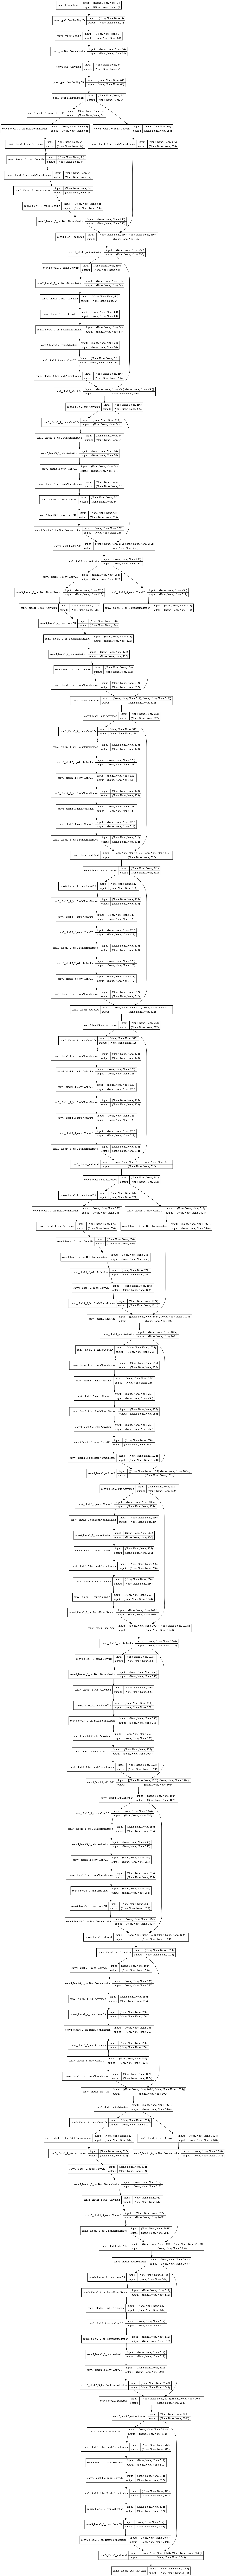

In [ ]:
keras.utils.plot_model(backbone, "resnet50.png", show_shapes=True)

In [ ]:
backbone.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

## Create RetinaNet Model

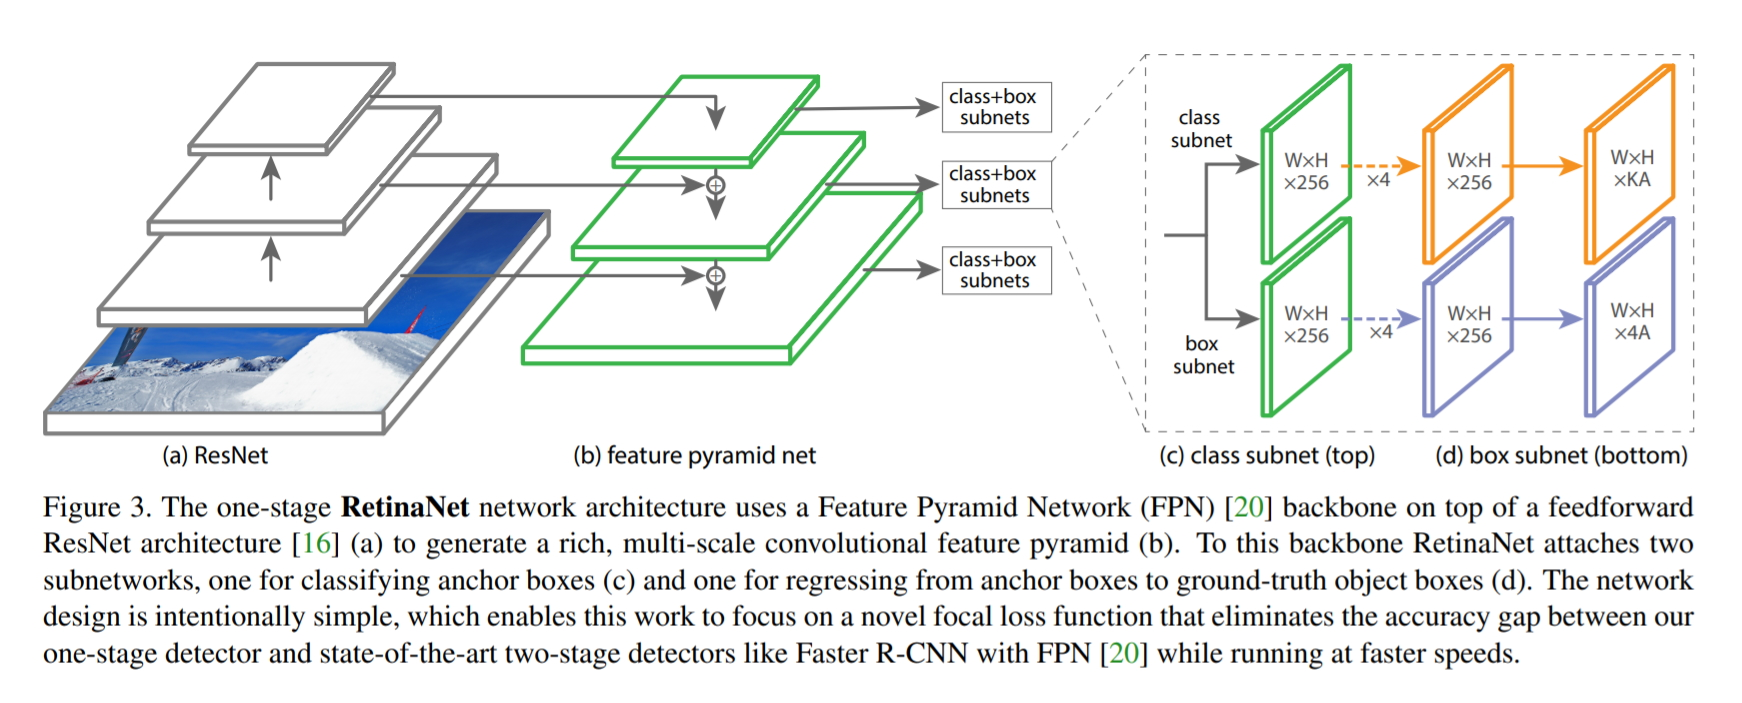

In [ ]:
def get_backbone():
  """Get pretrained resnet50 trained on imagenet
  
  """
  
  backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])

  c3_output, c4_output, c5_output = [
    backbone.get_layer(layer_name).output for layer_name in ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']                                  
  ]

  return keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])

In [ ]:
# Delete temporary variables
del backbone

### Building FPN

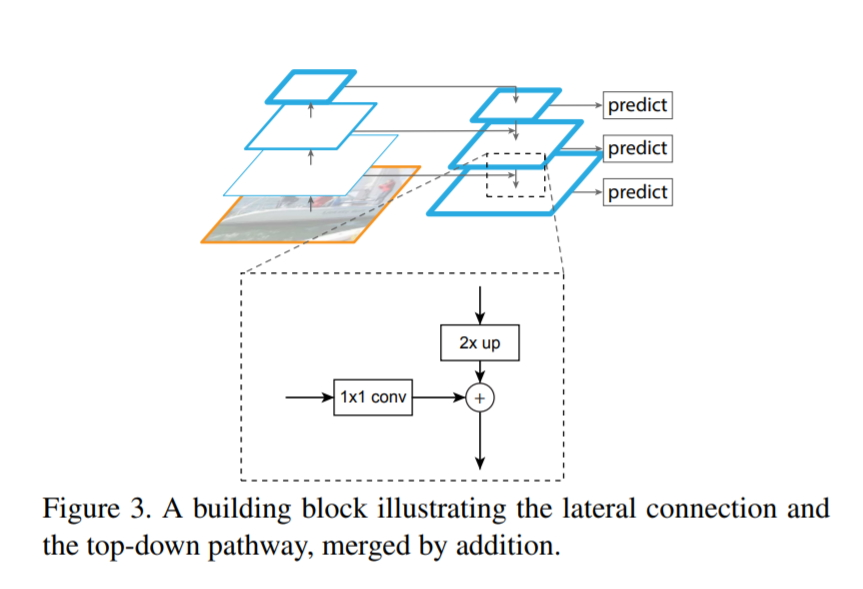

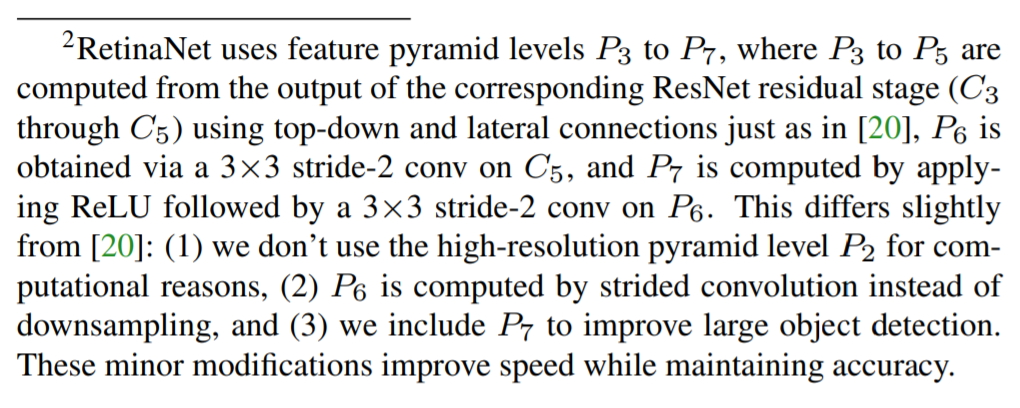

In [ ]:
class FeaturePyramid(keras.layers.Layer):
  """Build FPN with feature maps from backbone.

  References:
    FPN paper, Section 3, https://openaccess.thecvf.com/content_cvpr_2017/papers/Lin_Feature_Pyramid_Networks_CVPR_2017_paper.pdf
    RetinaNet paper, Section 4, https://arxiv.org/pdf/1708.02002.pdf
  """

  def __init__(self, backbone=None, **kwargs):
    super(FeaturePyramid, self).__init__(name='FeaturePyramid', **kwargs)
    self.backbone = backbone if backbone else get_backbone()
    
    self.conv_c3_1x1 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same') # 1x1 convolutions for lateral connections from backbone feature map 
    self.conv_c4_1x1 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')
    self.conv_c5_1x1 = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')

    self.conv_c3_3x3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same') # 3x3 convolutions for outputting feature maps to cls and box subnets
    self.conv_c4_3x3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')
    self.conv_c5_3x3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')

    self.conv_c6_3x3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same')
    self.conv_c7_3x3 = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same')

    self.upsampling_2x = keras.layers.UpSampling2D(size=(2,2))
    

  def call(self, images, training=False):
    c3_output, c4_output, c5_output = self.backbone(images, training=training)
    
    p3_output = self.conv_c3_1x1(c3_output)
    p4_output = self.conv_c4_1x1(c4_output)
    p5_output = self.conv_c5_1x1(c5_output)

    p4_output = p4_output + self.upsampling_2x(p5_output) # Connect 1x1 convolution features maps in FPN with top feature map by upsampling to element wise sum
    p3_output = p3_output + self.upsampling_2x(p4_output)

    p3_output = self.conv_c3_3x3(p3_output) # From each FPN levels generate outputs
    p4_output = self.conv_c4_3x3(p4_output)
    p5_output = self.conv_c5_3x3(p5_output)

    p6_output = self.conv_c6_3x3(c5_output) # Run convolution on backbone last output feature map to output from FPN
    p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))

    return p3_output, p4_output, p5_output, p6_output, p7_output

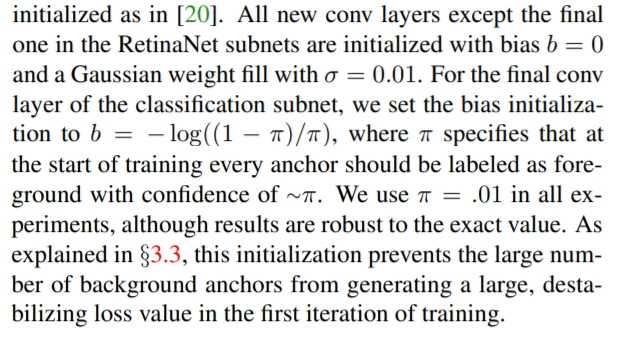

In [ ]:
def build_head(output_filters, bias_init):
  """Builds a general model that can be used as classificaiton or regression head.

  Arguments:
    output_filters: Number of conv filters in final layer since classification and regression head use same pattern except different filter count.
    bias_init: Bias initializer based paper reference.
  
  Returns:
    Keras sequential model representing classificaiton or bbox regression head based on `output_filters`.
  """

  head = keras.sequential([keras.Input(shape=[None, None, 256])]) # FPN features 256 channels output
  kernel_init = tf.initializers.RandomNormal(0.0, 0.01) # Initialize kernel from gaussian distribution with given standard deviation as in image above

  for _ in range(4):
    head.add(
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer=kernel_init)
    )
    head.add(keras.layers.ReLU())

  head.add(
      keras.layers.Conv2D(filters=output_filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init)
  )

  return head

### Why `__init__` and `call` function?
- This is referenced as documentation below to define layers in `__init__` and implement forward pass in `call` function. 

### Why `training` variable is used?
- To specify different train and test time behaviours.

https://keras.io/api/models/model/

In [ ]:
class RetinaNet(keras.Model):
  """RetinaNet subclassed model based on retinanet architecture.

  Has two output subnets one for classification with `num_classes * anchors` and for box regression `4 * anchors`.
  Box regression 4 represents left, top, right, bottom of a bbox.
  Here, 9 anchors are used represented in paper by `A`. `num_classes` is represented by `K` in paper.

  Attributes:
    num_classes: Number of classes for output.
    backbone: Feature extraction backbone.
  """

  def __init__(self, num_classes, backbone=None, **kwargs):
    super(RetinaNet, self).__init__(name='RetinaNet', **kwargs)
    
    self.fpn = FeaturePyramid(backbone)
    self.num_classes = num_classes

    prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))  # Uses bias formula as defined in the image above
    self.cls_head = build_head(output_filter=num_classes * 9, bias_init=prior_probability)  # Total ouput number of classes multiplied by number of anchors
    self.box_head = build_head(output_filter=4 * 9, bias_init='zeros')  # Total output 4 for bbox corners multiplied by number of anchors

  
  def call(self, image, training=False):
    feature = self.fpn(image, training=training)

    N = tf.shape(image)[0]
    cls_output = []
    box_output = []
    for feature in features:
      box_outputs.append(
          tf.reshape(self.box_head(feature), [N, -1, 4])
      )
      cls_output.append(
          tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
      )
    box_outputs = tf.concat(box_outputs, axis=1)
    cls_outputs = tf.concat(cls_outputs, axis=1)

    return tf.concat([cls_outputs, box_outputs], axis=1)

NameError: ignored

In [ ]:
model_dir = 'retinanet/'
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]

learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [ ]:
resnet50_backbone = get_backbone()

loss_fn = RetinaNetLoss(num_classes)  # Get custom loss function
model = RetinaNet(num_classes, resnet50_backbone)    

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

## Code Test

**Reshape Example**

In [ ]:
t = [[[1, 1, 1],
      [2, 2, 2]],
     [[3, 3, 3],
      [4, 4, 4]],
     [[5, 5, 5],
      [6, 6, 6]]]
      
t = tf.convert_to_tensor(t)
print(t.shape)

print(tf.reshape(t, [3, -1, 6]))

(3, 2, 3)
tf.Tensor(
[[[1 1 1 2 2 2]]

 [[3 3 3 4 4 4]]

 [[5 5 5 6 6 6]]], shape=(3, 1, 6), dtype=int32)


**Concat Example**

In [ ]:
t1 = [[1, 2, 3], [4, 5, 6]]
t2 = [[7, 8, 9], [10, 11, 12]]
t3 = [
        [
          [7, 8, 9], [10, 11, 12]
        ],
        [
          [5, 80, 19], [120, 121, 142]
        ],
      ]

print(tf.concat([t1, t2], axis=0))
print()
print(tf.concat([t1, t2], axis=1))
print()
print(tf.concat(t1, axis=0))
print()
print(tf.concat(t3, axis=1))

tf.Tensor(
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]], shape=(4, 3), dtype=int32)

tf.Tensor(
[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]], shape=(2, 6), dtype=int32)

tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int32)

tf.Tensor(
[[  7   8   9   5  80  19]
 [ 10  11  12 120 121 142]], shape=(2, 6), dtype=int32)
